#### Author: Gioele Eterno

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Regression

## Data Preparation
- prepare your data for the regression task (univariate and multivariate)
- decide a continuous variable to predict
- remove all the variable that are not necessary or "leak" information about your target.
- divide the dataset in train/test
- for each classifier perform the correct preprocessing.

As always we start by reading the output file from the first notebook

In [67]:
df = pd.read_csv('aac_dogs_01.csv')
df.head()

,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,outcome_datetime,breed,color,intake_condition,intake_type,sex_upon_intake,...,playfulness,protectiveness,trainability,energy,barking,breed_type,top6_breeds,age_upon_intake,age_upon_outcome,length_of_stay
0,2017-03-08,Foster,Adoption,Intact Male,2017-05-09 07:48:00,Greyhound Mix,Tan,Normal,Stray,Intact Male,...,3.191688,3.390986,2.873580,4.167703,1.974363,mix,False,0.084932,0.169863,0.082192
1,2016-07-03,Foster,Adoption,Spayed Female,2016-09-10 17:22:00,Boxer Mix,Brown/White,Normal,Stray,Intact Female,...,3.916796,3.144705,3.010407,4.231642,2.737943,mix,False,0.101370,0.189041,0.087671
2,2010-02-10,Partner,Transfer,Intact Male,2018-03-01 16:27:00,Chihuahua Shorthair Mix,Red,Normal,Stray,Intact Male,...,3.577027,3.620172,1.832087,2.834511,5.015286,mix,True,8.043836,8.057534,0.013699
3,2006-10-22,Partner,Transfer,Neutered Male,2015-10-28 14:12:00,Pomeranian Mix,White/Black,Normal,Stray,Intact Male,...,2.203599,3.770284,3.482516,2.037904,3.420557,mix,False,9.005479,9.021918,0.016438
4,2016-09-07,Partner,Transfer,Spayed Female,2017-09-16 16:01:00,Shih Tzu Mix,White/Brown,Normal,Stray,Spayed Female,...,3.094009,2.924166,4.698562,2.944130,2.754888,mix,False,1.013699,1.024658,0.010959


Since the aim of this part of the project is to do regression, in order to have more meaningful results it's necessary to consider only those features that have a correlation which is significantly different from zero. This can be analyzed firstly by having a look at the correlation matrix:

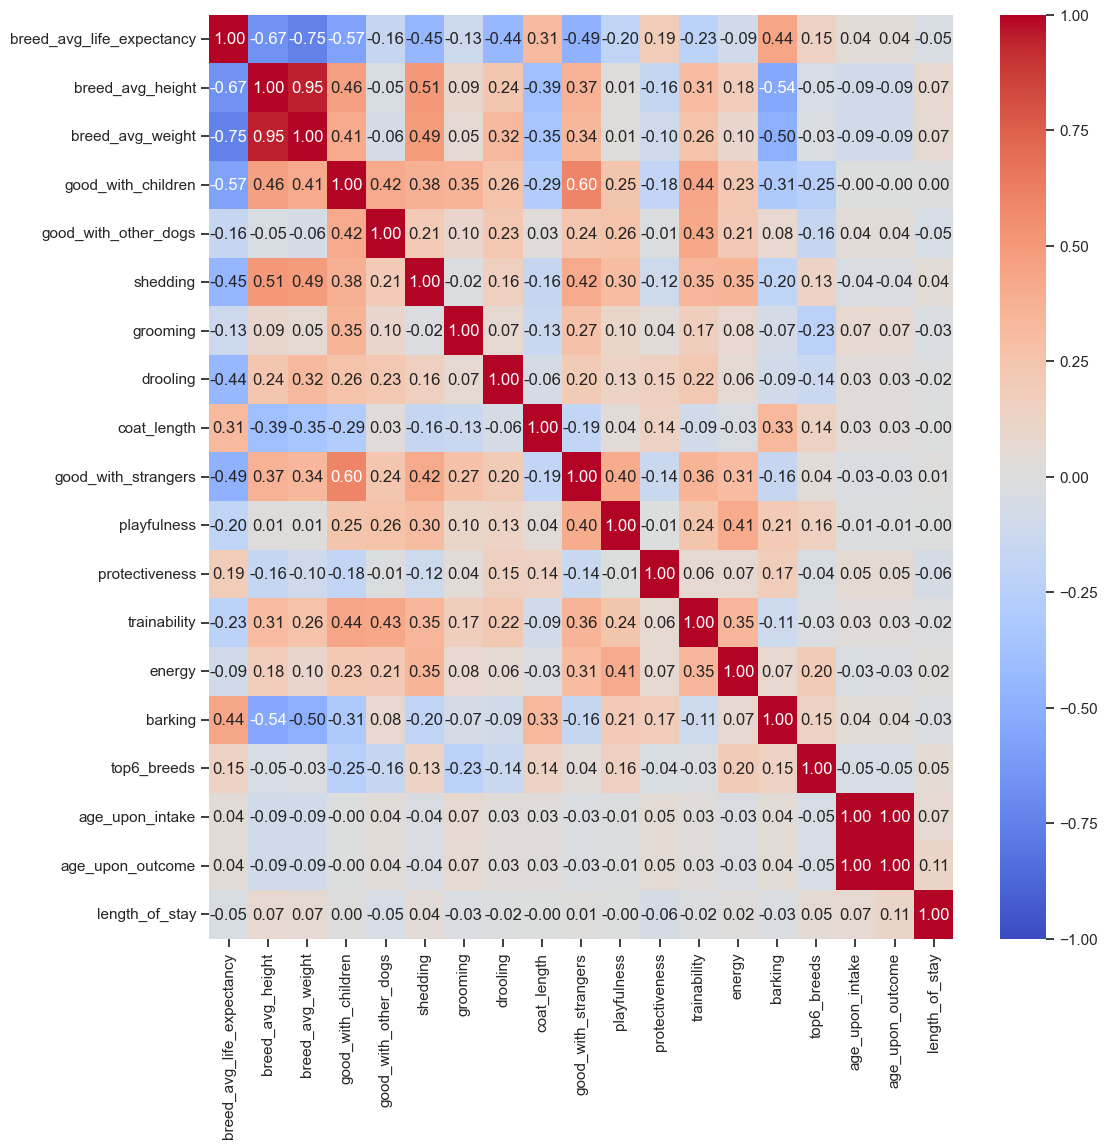

In [68]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(numeric_only = True),fmt= '.2f',cmap="coolwarm", vmin=-1, vmax=1, annot=True)
plt.show()

A thing to clarify immediately is that it doesn't make sense to compare features that are constant for each breed (like `breed_avg_life_expectancy` etc.) with features which instead take different values for each dog. So no regression is done between these two type of features.

A block with high (absolute) values of the correlation is that formed by `breed_avg_life_expectancy`, `breed_avg_height` and `breed_avg_weight`.
Let's have a look at the scatter matrix of these variables:

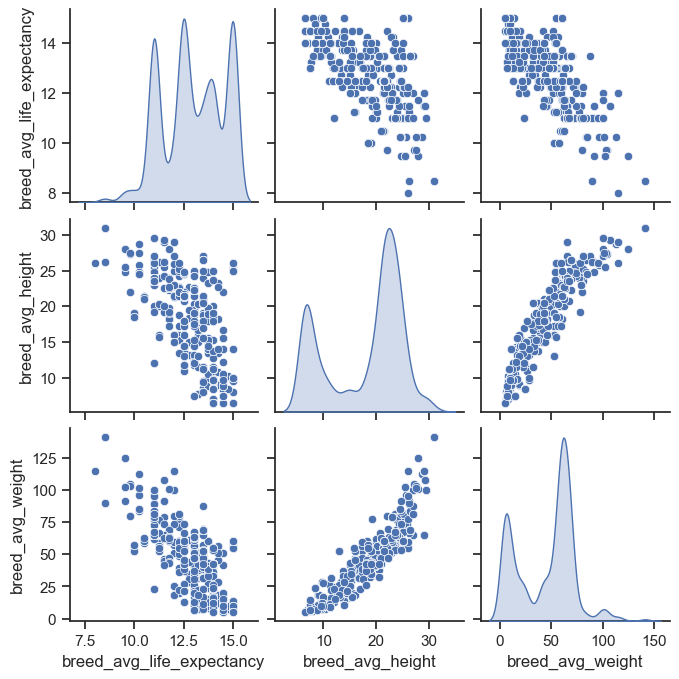

In [69]:
sns.set_theme(style="ticks")
sns.pairplot(df, diag_kind="kde",
    x_vars=['breed_avg_life_expectancy', 'breed_avg_height', 'breed_avg_weight'],
    y_vars=['breed_avg_life_expectancy', 'breed_avg_height', 'breed_avg_weight'],
    height=2.3)

plt.show()

To evaluate the significance of the correlation we can do as follows:

In [70]:
print(stats.pearsonr(df['breed_avg_height'], df['breed_avg_weight']))
print(stats.pearsonr(df['breed_avg_life_expectancy'], df['breed_avg_weight']))
print(stats.pearsonr(df['breed_avg_life_expectancy'], df['breed_avg_height']))

PearsonRResult(statistic=0.9506974305419669, pvalue=0.0)
PearsonRResult(statistic=-0.7496996150663391, pvalue=0.0)
PearsonRResult(statistic=-0.6655948027656383, pvalue=0.0)


The results show significant correlations with confidence level of $95\%$ (the pvalue is lower than $0.05$). So these variables can be used to do regressions.

By considering instead the dog specific features, `good_with_children` seems to correlate with various other features so we can consider to predict it. This is the scatter plot visualization:

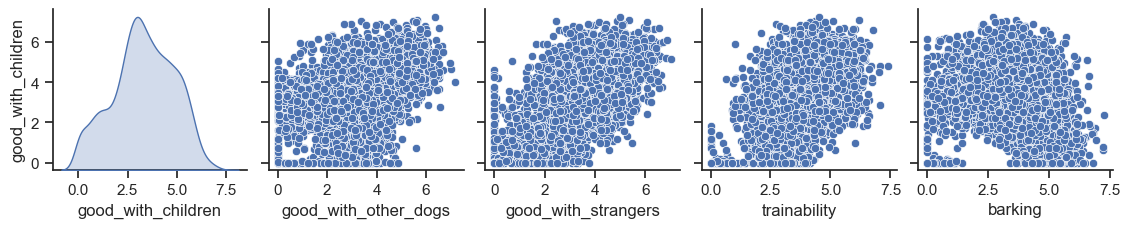

In [71]:
sns.set_theme(style="ticks")
sns.pairplot(df, diag_kind="kde",
    x_vars=['good_with_children', 'good_with_other_dogs','good_with_strangers', 'trainability', 'barking'],
    y_vars=['good_with_children'],
    height=2.3)

plt.show()

Of course the relationships between the variables are less evident than the breed specific case but the correlation is significant at $95\%$ confidence level since

In [72]:
print(stats.pearsonr(df['good_with_children'], df['good_with_strangers']))
print(stats.pearsonr(df['good_with_children'], df['trainability']))
print(stats.pearsonr(df['good_with_children'], df['good_with_other_dogs']))
print(stats.pearsonr(df['good_with_children'], df['barking']))

PearsonRResult(statistic=0.5969259353811485, pvalue=0.0)
PearsonRResult(statistic=0.4428434995345072, pvalue=1.5642736457537952e-209)
PearsonRResult(statistic=0.41719458518317776, pvalue=8.320723169325038e-184)
PearsonRResult(statistic=-0.3054071322814473, pvalue=4.3544114864317874e-95)


and the pvalue for each couple of features is way lower than $0.05$. So this variables can be used for regression.

A useful metric for comparing regression models with different number of parameters is the adjusted-$R^2$ which is defined as follows as a function of $R^2$, the number of observation $n$ and the number of regressors $k$:

In [73]:
def adj_R2(R2, n, k): # n = number of observation, k = number of independent variables
    return 1 - ((1 - R2)*(n - 1)/(n - k - 1))

The higher the adjusted-$R^2$ the better the model.

## Dummy
It's always a good idea to understand how well a naive model performs. You can use the DummyRegressor for that. If your next model do worse than naive... well, you may have a problem!

In [74]:
from sklearn.dummy import DummyRegressor

In [75]:
dummy_reg = DummyRegressor()

The first dummy regression that we do is that of `breed_avg_height` vs `breed_avg_weight`. To do that we split the samples into train and set:

In [76]:
height = df['breed_avg_height'].values
weight = df['breed_avg_weight'].values

height_train, height_test, weight_train, weight_test = train_test_split(height, weight, test_size=0.3, random_state=0)

We `fit` on the training set and `predict` on the test set:

In [77]:
dummy_reg.fit(height_train, weight_train)
weight_pred_dummy = dummy_reg.predict(height_test)

Visually the result of the regression is the following:

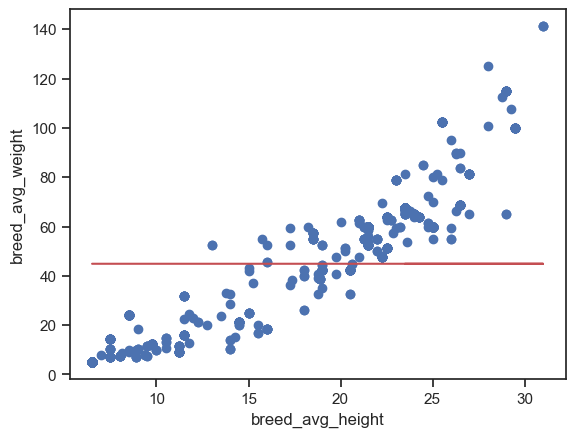

In [78]:
plt.scatter(height_test, weight_test)
plt.plot(height_test, weight_pred_dummy, c='r')
plt.xlabel('breed_avg_height')
plt.ylabel('breed_avg_weight')
plt.show()

and to have some quantitative metrics to evaluate the result we can consider the 'mean squared error' (MSE), the 'mean absolute error' (MAE), the '$R^2$' and the 'adjusted-$R^2$'

In [79]:
print('MSE: ',mean_squared_error(weight_test, weight_pred_dummy))
print('MAE: ',mean_absolute_error(weight_test, weight_pred_dummy))
print('R^2: ', r2_score(weight_test, weight_pred_dummy))
print('Adjusted R^2: ',adj_R2(r2_score(weight_test, weight_pred_dummy), len(weight_test), 0))

MSE:  771.6504888481571
MAE:  24.017943980146764
R^2:  -0.001397208473026268
Adjusted R^2:  -0.001397208473026268


Particularily significant is the $R^2$ metric that ranging between $0$ (bad fit) and $1$ (perfect fit) tells us how good is the model in representing the data. In this case $R^2 \simeq -0.001$ so as expected the fit is really bad.

Another dummy regression that we do is that of `breed_avg_weight` vs `breed_avg_life_expectancy`. To do that we split the samples into train and set:

In [80]:
weight = df['breed_avg_weight'].values
avg_life = df['breed_avg_life_expectancy'].values

weight_train, weight_test, avg_life_train, avg_life_test = train_test_split(weight, avg_life, test_size=0.3, random_state=0)

Again we `fit` on the training set and `predict` on the test set:

In [81]:
dummy_reg.fit(weight_train, avg_life_train)
avg_life_pred_dummy = dummy_reg.predict(weight_test)

Visually the result of the regression is the following:

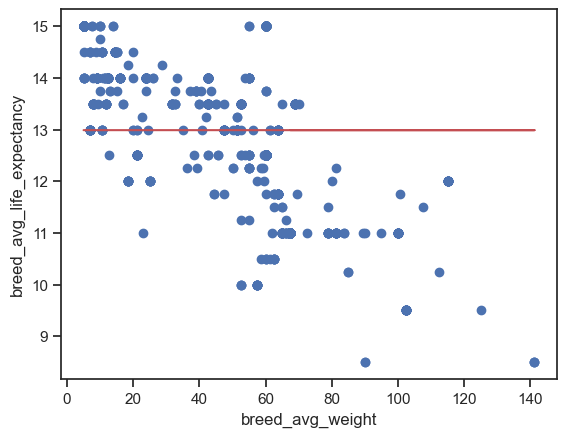

In [82]:
plt.scatter(weight_test, avg_life_test)
plt.plot(weight_test, avg_life_pred_dummy, c='r')
plt.xlabel('breed_avg_weight')
plt.ylabel('breed_avg_life_expectancy')
plt.show()

and to have some quantitative metrics to evaluate the result we can consider the 'mean squared error' (MSE), the 'mean absolute error' (MAE), the '$R^2$' and the 'adjusted-$R^2$'

In [83]:
print('MSE: ',mean_squared_error(avg_life_test, avg_life_pred_dummy))
print('MAE: ',mean_absolute_error(avg_life_test, avg_life_pred_dummy))
print('R^2: ', r2_score(avg_life_test, avg_life_pred_dummy))
print('Adjusted R^2: ',adj_R2(r2_score(avg_life_test, avg_life_pred_dummy), len(avg_life_test), 0))

MSE:  2.4325364555410225
MAE:  1.3406083785570524
R^2:  -0.0012335565179082408
Adjusted R^2:  -0.0012335565179082408


Also in this case $R^2 \simeq -0.001$ so as expected the fit is really bad.

Another dummy regression that we do is that of `good_with_strangers` vs `good_with_children`. To do that we split the samples into train and set:

In [84]:
good_w_strangers = df['good_with_strangers'].values
good_w_children = df['good_with_children'].values

good_w_strangers_train, good_w_strangers_test, good_w_children_train, good_w_children_test = train_test_split(good_w_strangers, good_w_children, test_size=0.3, random_state=0)

Again we `fit` on the training set and `predict` on the test set:

In [85]:
dummy_reg.fit(good_w_strangers_train, good_w_children_train)
good_w_children_pred_dummy = dummy_reg.predict(good_w_strangers_test)

Visually the result of the regression is the following:

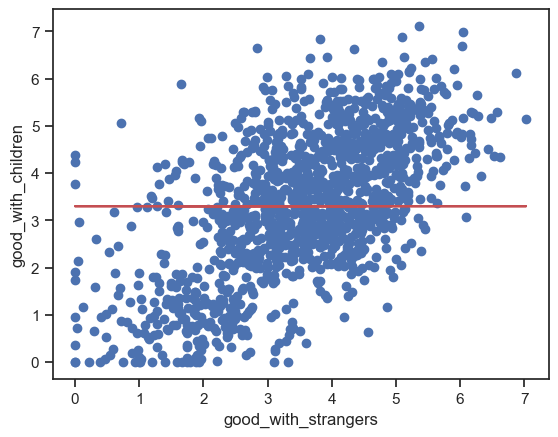

In [86]:
plt.scatter(good_w_strangers_test, good_w_children_test)
plt.plot(good_w_strangers_test, good_w_children_pred_dummy, c='r')
plt.xlabel('good_with_strangers')
plt.ylabel('good_with_children')
plt.show()

and to have some quantitative metrics to evaluate the result we can consider the 'mean squared error' (MSE), the 'mean absolute error' (MAE), the '$R^2$' and the 'adjusted-$R^2$'

In [87]:
print('MSE: ',mean_squared_error(good_w_children_test, good_w_children_pred_dummy))
print('MAE: ',mean_absolute_error(good_w_children_test, good_w_children_pred_dummy))
print('R^2: ', r2_score(good_w_children_test, good_w_children_pred_dummy))
print('Adjusted R^2: ',adj_R2(r2_score(good_w_children_test, good_w_children_pred_dummy), len(good_w_children_test), 0))

MSE:  2.306302733157931
MAE:  1.2405669488799047
R^2:  -0.00017149103559033207
Adjusted R^2:  -0.00017149103559033207


In this case $R^2 \simeq -0.0001$ so as expected the fit is really bad (actually is the worst among the various dummy fits that have been done).

## Univariate
- Use univariate linear regression to predict the target variable.
- Evaluate the performance of the regressor using metrics and/or plots.

The dummy regression as expected performs always very bad, so let's now do a more proper regression by considering univariate regression.

All the univariate (as well as the multivariate in the next section) will be done by using the `OLS` class inside the `statsmodel.api` library which was introduced in the 'Statistical Methods for Data Science' course. It's a nice tool because it allows to compactly visualize (through the `summary()` method) all the relevant informations about the regressions including useful statistical metrics like the t-statistic, the F-statistic and also goodness of fit metrics like the $R^2$, the adjusted-$R^2$, the AIC and the BIC (which are useful when comparing models with different number of parameters).

The first univariate regression that we do is `breed_avg_height` vs `breed_avg_weight`. To do that we split the samples into train and set:

As before, we fit on the training set (the `add_constant` method is used to consider also the intercept in the model)

In [88]:
lm1_height_weight = sm.OLS(weight_train, sm.add_constant(height_train)).fit()

Quantitatively the result of the fit are the following:

In [89]:
print(lm1_height_weight.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                 2.875e+04
Date:                Sun, 09 Mar 2025   Prob (F-statistic):               0.00
Time:                        12:05:49   Log-Likelihood:                -10889.
No. Observations:                3061   AIC:                         2.178e+04
Df Residuals:                    3059   BIC:                         2.179e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20.0649      0.413    -48.616      0.0

The results are quite good (on the training set) since both parameters of the regression are significantly different from zero (with confidence level $95\%$ since $(P>|t|) < 0.05$) and the $R^2 = 0.904$.

Then we predict on the test set:

In [90]:
weight_pred_lm1 = lm1_height_weight.predict(sm.add_constant(height_test))

And visually the result is the following:

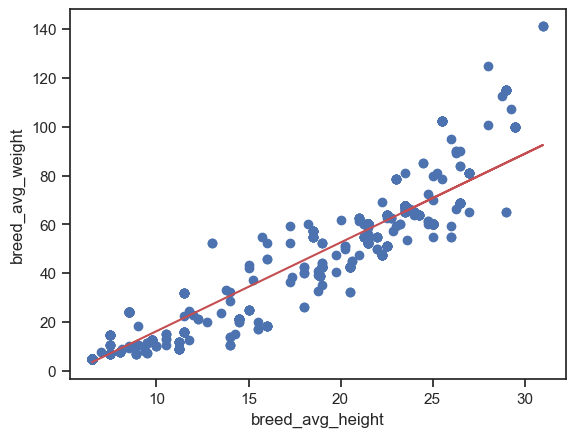

In [91]:
plt.scatter(height_test, weight_test)
plt.plot(height_test, weight_pred_lm1, c='r')
plt.xlabel('breed_avg_height')
plt.ylabel('breed_avg_weight')
plt.show()

To evaluate the result on the test set we compute as always the 'MSE', 'MAE', '$R^2$' and 'adjusted-$R^2$' metrics:

In [92]:
print('MSE: ',mean_squared_error(weight_test, weight_pred_lm1))
print('MAE: ',mean_absolute_error(weight_test, weight_pred_lm1))
print('R^2: ', r2_score(weight_test, weight_pred_lm1))
print('Adjusted R^2: ',adj_R2(r2_score(weight_test, weight_pred_lm1), len(weight_test), 1))

MSE:  74.23859999186996
MAE:  5.787352701943956
R^2:  0.903658031884649
Adjusted R^2:  0.9035845444947822


On the test set $R^2 = 0.904$ so the regression is actually good.

From the plot above we can see that the datapoints can be better fitted by a quadratic function. We explicitly do that adding another regressor which is `breed_avg_height`$^2$. The regression is still linear since the dependence between the target variable and the parameters is linear.

Practically this is done by using the method `vander` in `Numpy` on the training set of `breed_avg_height`.

In [93]:
lm2_height_weight = sm.OLS(weight_train, np.vander(height_train, 3, increasing=True)).fit()

Quantitatively the result of the fit are the following:

In [94]:
print(lm2_height_weight.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                 1.727e+04
Date:                Sun, 09 Mar 2025   Prob (F-statistic):               0.00
Time:                        12:05:50   Log-Likelihood:                -10632.
No. Observations:                3061   AIC:                         2.127e+04
Df Residuals:                    3058   BIC:                         2.129e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8425      0.860     -2.143      0.0

The results are quite good (on the training set) since all three parameters of the regression are significantly different from zero (with confidence level $95\%$ since $(P>|t|) < 0.05$) and the $R^2 = 0.919$.

Then we predict on the test set:

In [95]:
weight_pred_lm2 = lm2_height_weight.predict(np.vander(height_test, 3, increasing=True))

And visually the result is the following:

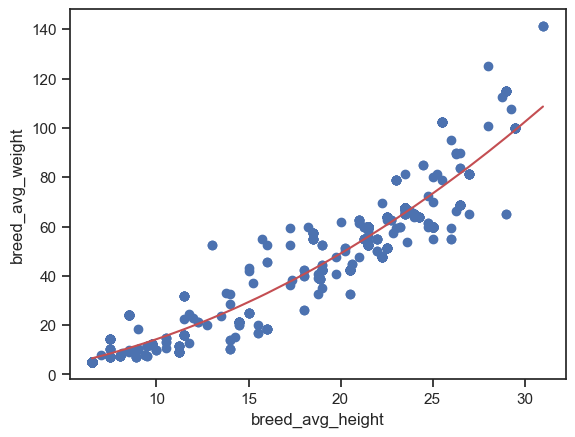

In [96]:
plt.scatter(height_test, weight_test)
plt.plot(np.sort(height_test), np.sort(weight_pred_lm2), c='r')
plt.xlabel('breed_avg_height')
plt.ylabel('breed_avg_weight')
plt.show()

To evaluate the result on the test set we compute as always the 'MSE', 'MAE', '$R^2$' and 'adjusted-$R^2$' metrics:

In [97]:
print('MSE: ',mean_squared_error(weight_test, weight_pred_lm2))
print('MAE: ',mean_absolute_error(weight_test, weight_pred_lm2))
print('R^2: ', r2_score(weight_test, weight_pred_lm2))
print('Adjusted R^2: ',adj_R2(r2_score(weight_test, weight_pred_lm2), len(weight_test), 1))

MSE:  61.86545934323398
MAE:  5.510065424924078
R^2:  0.9197150793234232
Adjusted R^2:  0.9196538398721062


Also on the test set $R^2 = 0.904$ so the regression is actually good and better than the strictly univariate approach (this also shown by the higher values in AIC and BIC in the strictly univariate case). Remember that the lower the AIC/BIC the better the model.

Another univariate regression that we do is `breed_avg_weight` vs `breed_avg_life_expectancy`. To do that we split the samples into train and set:

As before, we fit on the training set (the `add_constant` method is used to consider also the intercept in the model)

In [98]:
lm_weight_life = sm.OLS(avg_life_train, sm.add_constant(weight_train)).fit()

Quantitatively the result of the fit are the following:

In [99]:
print(lm_weight_life.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     3835.
Date:                Sun, 09 Mar 2025   Prob (F-statistic):               0.00
Time:                        12:05:50   Log-Likelihood:                -4382.7
No. Observations:                3061   AIC:                             8769.
Df Residuals:                    3059   BIC:                             8781.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.8499      0.035    421.906      0.0

The results are not as good (on the training set) as the `breed_avg_height` vs `breed_avg_weight` case. Anyway both parameters of the regression are significantly different from zero (with confidence level $95\%$ since $(P>|t|) < 0.05$) and the $R^2 = 0.556$.

Then we predict on the test set:

In [100]:
avg_life_pred_lm = lm_weight_life.predict(sm.add_constant(weight_test))

And visually the result is the following:

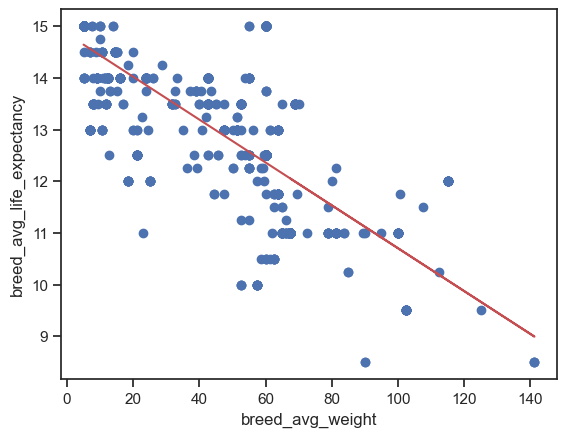

In [101]:
plt.scatter(weight_test, avg_life_test)
plt.plot(weight_test, avg_life_pred_lm, c='r')
plt.xlabel('breed_avg_weight')
plt.ylabel('breed_avg_life_expectancy')
plt.show()

To evaluate the result on the test set we compute as always the 'MSE', 'MAE', '$R^2$' and 'adjusted-$R^2$' metrics:

In [102]:
print('MSE: ',mean_squared_error(avg_life_test, avg_life_pred_lm))
print('MAE: ',mean_absolute_error(avg_life_test, avg_life_pred_lm))
print('R^2: ', r2_score(avg_life_test, avg_life_pred_lm))
print('Adjusted R^2: ',adj_R2(r2_score(avg_life_test, avg_life_pred_lm), len(avg_life_test), 1))

MSE:  1.0342675546402118
MAE:  0.7565183891970679
R^2:  0.5742948148774267
Adjusted R^2:  0.5739700969635271


On the test set $R^2 = 0.595$ so as expected the regression is worse than the `breed_avg_height` vs `breed_avg_weight` case.

Another univariate regression that we do is `good_with_strangers` vs `good_with_children`. To do that we split the samples into train and set:

As before, we fit on the training set (the `add_constant` method is used to consider also the intercept in the model)

In [103]:
lm_strangers_children = sm.OLS(good_w_children_train, sm.add_constant(good_w_strangers_train)).fit()

Quantitatively the result of the fit are the following:

In [104]:
print(lm_strangers_children.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     1670.
Date:                Sun, 09 Mar 2025   Prob (F-statistic):          1.19e-291
Time:                        12:05:50   Log-Likelihood:                -5040.5
No. Observations:                3061   AIC:                         1.008e+04
Df Residuals:                    3059   BIC:                         1.010e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7850      0.066     11.966      0.0

The results are not as good (on the training set) as the `breed_avg_height` vs `breed_avg_weight` or the `breed_avg_weight` vs `breed_avg_life_expectancy` case. Anyway both parameters of the regression are significantly different from zero (with confidence level $95\%$ since $(P>|t|) < 0.05$) and the $R^2 = 0.353$.

Then we predict on the test set:

In [105]:
good_w_children_pred_lm = lm_strangers_children.predict(sm.add_constant(good_w_strangers_test))

And visually the result is the following:

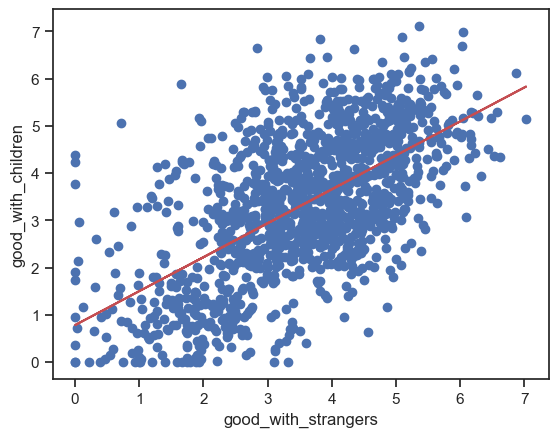

In [106]:
plt.scatter(good_w_strangers_test, good_w_children_test)
plt.plot(good_w_strangers_test, good_w_children_pred_lm, c='r')
plt.xlabel('good_with_strangers')
plt.ylabel('good_with_children')
plt.show()

To evaluate the result on the test set we compute as always the 'MSE', 'MAE', '$R^2$' and 'adjusted-$R^2$' metrics:

In [107]:
print('MSE: ',mean_squared_error(good_w_children_test, good_w_children_pred_lm))
print('MAE: ',mean_absolute_error(good_w_children_test, good_w_children_pred_lm))
print('R^2: ', r2_score(good_w_children_test, good_w_children_pred_lm))
print('Adjusted R^2: ',adj_R2(r2_score(good_w_children_test, good_w_children_pred_lm), len(good_w_children_test), 1))

MSE:  1.466085781226815
MAE:  0.9889048028313802
R^2:  0.36420436887402763
Adjusted R^2:  0.3637193989036799


On the test set $R^2 = 0.364$ so as expected the regression is worse than both `breed_avg_height` vs `breed_avg_weight` and `breed_avg_weight` vs `breed_avg_life_expectancy` cases.

## Multivariate
- Use multivariate linear regression to predict the target variable.
- Use two other multivariate regressors to predict the target variable.
- Evaluate and compare the performance of the regressors using metrics and/or plots.

The first multivariate regression we consider is `breed_avg_height`-`breed_avg_weight` vs `breed_avg_life_expectancy`. To do that we split the samples into train and set:

In [108]:
height_weight = df[['breed_avg_height', 'breed_avg_weight']]

height_weight_train, height_weight_test, avg_life_train, avg_life_test = train_test_split(height_weight, avg_life, test_size=0.3, random_state=0)

As before, we fit on the training set (the `add_constant` method is used to consider also the intercept in the model)

In [109]:
lm_height_weight_life = sm.OLS(avg_life_train, sm.add_constant(height_weight_train)).fit()

Quantitatively the result of the fit are the following:

In [110]:
print(lm_height_weight_life.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     2112.
Date:                Sun, 09 Mar 2025   Prob (F-statistic):               0.00
Time:                        12:05:50   Log-Likelihood:                -4298.6
No. Observations:                3061   AIC:                             8603.
Df Residuals:                    3058   BIC:                             8621.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               14.1418      0.064  

The results are not as good (on the training set) as the simple univariate `breed_avg_height` vs `breed_avg_weight` case. Anyway all three parameters of the regression are significantly different from zero (with confidence level $95\%$ since $(P>|t|) < 0.05$) and the $R^2 = 0.580$.

Then we predict on the test set:

In [111]:
avg_life_pred_lm = lm_height_weight_life.predict(sm.add_constant(height_weight_test))

To evaluate the result on the test set we compute as always the 'MSE', 'MAE', '$R^2$' and 'adjusted-$R^2$' metrics:

In [112]:
print('MSE: ',mean_squared_error(avg_life_test, avg_life_pred_lm))
print('MAE: ',mean_absolute_error(avg_life_test, avg_life_pred_lm))
print('R^2: ', r2_score(avg_life_test, avg_life_pred_lm))
print('Adjusted R^2: ',adj_R2(r2_score(avg_life_test, avg_life_pred_lm), len(avg_life_test), 2))

MSE:  0.9812607732080929
MAE:  0.7696541890584189
R^2:  0.5961124399214239
Adjusted R^2:  0.5954958176922963


On the test set $R^2 = 0.596$ so as expected the regression is worse than the `breed_avg_height` vs `breed_avg_weight` univariate case.

Another multivariate regression we consider is `good_with_strangers`-`trainability` vs `good_with_children`. To do that we split the samples into train and set:

In [113]:
strangers_trainability = df[['good_with_strangers', 'trainability']]

strangers_trainability_train, strangers_trainability_test, good_w_children_train, good_w_children_test = \
train_test_split(strangers_trainability, good_w_children, test_size=0.3, random_state=0)

As before, we fit on the training set (the `add_constant` method is used to consider also the intercept in the model)

In [114]:
lm_strangers_trainability_children = sm.OLS(good_w_children_train, sm.add_constant(strangers_trainability_train)).fit()

Quantitatively the result of the fit are the following:

In [115]:
print(lm_strangers_trainability_children.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     1085.
Date:                Sun, 09 Mar 2025   Prob (F-statistic):               0.00
Time:                        12:05:51   Log-Likelihood:                -4886.4
No. Observations:                3061   AIC:                             9779.
Df Residuals:                    3058   BIC:                             9797.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1661    

The results are not as good (on the training set) as the multivariate `breed_avg_height`-`breed_avg_weight` vs `breed_avg_life_expectancy` case but are better than the simple univariate case `good_with_strangers` vs `good_with_children`. All three parameters of the regression are significantly different from zero (with confidence level $95\%$ since $(P>|t|) < 0.05$) and the $R^2 = 0.415$.

Then we predict on the test set:

In [116]:
good_w_children_pred_lm = lm_strangers_trainability_children.predict(sm.add_constant(strangers_trainability_test))

To evaluate the result on the test set we compute as always the 'MSE', 'MAE', '$R^2$' and 'adjusted-$R^2$' metrics:

In [117]:
print('MSE: ',mean_squared_error(good_w_children_test, good_w_children_pred_lm))
print('MAE: ',mean_absolute_error(good_w_children_test, good_w_children_pred_lm))
print('R^2: ', r2_score(good_w_children_test, good_w_children_pred_lm))
print('Adjusted R^2: ',adj_R2(r2_score(good_w_children_test, good_w_children_pred_lm), len(good_w_children_test), 2))

MSE:  1.3390010213294625
MAE:  0.9327185860109322
R^2:  0.4193170615691417
Adjusted R^2:  0.41843052273184267


On the test set $R^2 = 0.419$ so as expected the regression is worse than the multivariate `breed_avg_height`-`breed_avg_weight` vs `breed_avg_life_expectancy` case but better than the simple univariate case `good_with_strangers` vs `good_with_children`.

Another multivariate regression we consider is `good_with_other_dogs`-`barking` vs `good_with_children`. To do that we split the samples into train and set:

In [118]:
good_w_dogs_barking = df[['good_with_other_dogs', 'barking']]

good_w_dogs_barking_train, good_w_dogs_barking_test, good_w_children_train, good_w_children_test = \
train_test_split(good_w_dogs_barking, good_w_children, test_size=0.3, random_state=0)

As before, we fit on the training set (the `add_constant` method is used to consider also the intercept in the model)

In [119]:
lm_good_w_dogs_barking_children = sm.OLS(good_w_children_train, sm.add_constant(good_w_dogs_barking_train)).fit()

Quantitatively the result of the fit are the following:

In [120]:
print(lm_good_w_dogs_barking_children.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     616.8
Date:                Sun, 09 Mar 2025   Prob (F-statistic):          8.94e-226
Time:                        12:05:51   Log-Likelihood:                -5188.4
No. Observations:                3061   AIC:                         1.038e+04
Df Residuals:                    3058   BIC:                         1.040e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.1776 

The results in this case are not as good (on the training set) as the multivariate `good_with_strangers`-`trainability` vs `good_with_children` case. Anyway all three parameters of the regression are significantly different from zero (with confidence level $95\%$ since $(P>|t|) < 0.05$) and the $R^2 = 0.287$.

Then we predict on the test set:

In [121]:
good_w_children_pred_lm = lm_good_w_dogs_barking_children.predict(sm.add_constant(good_w_dogs_barking_test))

To evaluate the result on the test set we compute as always the 'MSE', 'MAE', '$R^2$' and 'adjusted-$R^2$' metrics:

In [122]:
print('MSE: ',mean_squared_error(good_w_children_test, good_w_children_pred_lm))
print('MAE: ',mean_absolute_error(good_w_children_test, good_w_children_pred_lm))
print('R^2: ', r2_score(good_w_children_test, good_w_children_pred_lm))
print('Adjusted R^2: ',adj_R2(r2_score(good_w_children_test, good_w_children_pred_lm), len(good_w_children_test), 2))

MSE:  1.6252346946554024
MAE:  1.033145824965309
R^2:  0.2951864538570296
Adjusted R^2:  0.2941104026415441


On the test set $R^2 = 0.295$ so as expected the regression is worse than the multivariate `good_with_strangers`-`trainability` vs `good_with_children` case.

As a final regression let's try to predict `good_with_children` by using all $4$ regressors `good_with_strangers`-`trainability`-`good_with_other_dogs`-`barking`.

In [123]:
good_w_strangers_dogs_trainability_barking = df[['good_with_strangers','trainability','good_with_other_dogs', 'barking']]

good_w_strangers_dogs_trainability_barking_train, good_w_strangers_dogs_trainability_barking_test, good_w_children_train, good_w_children_test = \
train_test_split(good_w_strangers_dogs_trainability_barking, good_w_children, test_size=0.3, random_state=0)

As before, we fit on the training set (the `add_constant` method is used to consider also the intercept in the model)

In [124]:
lm_good_w_strangers_dogs_trainability_barking = sm.OLS(good_w_children_train, sm.add_constant(good_w_strangers_dogs_trainability_barking_train)).fit()

Quantitatively the result of the fit are the following:

In [125]:
print(lm_good_w_strangers_dogs_trainability_barking.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     795.7
Date:                Sun, 09 Mar 2025   Prob (F-statistic):               0.00
Time:                        12:05:51   Log-Likelihood:                -4614.8
No. Observations:                3061   AIC:                             9240.
Df Residuals:                    3056   BIC:                             9270.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.7538 

The results in this case are better than both the multivariate cases `good_with_strangers`-`trainability` vs `good_with_children` and `good_with_other_dogs`-`barking` vs `good_with_children`. All three parameters of the regression are significantly different from zero (with confidence level $95\%$ since $(P>|t|) < 0.05$) and the $R^2 = 0.510$.

Then we predict on the test set:

In [126]:
good_w_children_pred4_lm = lm_good_w_strangers_dogs_trainability_barking.predict(sm.add_constant(good_w_strangers_dogs_trainability_barking_test))

To evaluate the result on the test set we compute as always the 'MSE', 'MAE', '$R^2$' and 'adjusted-$R^2$' metrics:

In [127]:
print('MSE: ',mean_squared_error(good_w_children_test, good_w_children_pred4_lm))
print('MAE: ',mean_absolute_error(good_w_children_test, good_w_children_pred4_lm))
print('R^2: ', r2_score(good_w_children_test, good_w_children_pred4_lm))
print('Adjusted R^2: ',adj_R2(r2_score(good_w_children_test, good_w_children_pred4_lm), len(good_w_children_test), 2))

MSE:  1.1110963011926542
MAE:  0.8503650871298478
R^2:  0.5181522233525933
Adjusted R^2:  0.5174165778920629


On the test set $R^2 = 0.518$ so as expected the regression is better than both the multivariate cases `good_with_strangers`-`trainability` vs `good_with_children` and `good_with_other_dogs`-`barking` vs `good_with_children`.